In [366]:
import seaborn as sns
import matplotlib.pyplot as plt
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import warnings;warnings.filterwarnings('ignore')

import pandas as pd
import re
import math
import numpy as np
from lightgbm import LGBMRegressor
import time

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [367]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
bus_feature = pd.read_csv('./data/bus_feature.csv')
subway_feature = pd.read_csv('./data/subway_feature.csv')
address = pd.read_csv('./data/addresses.csv')
school = pd.read_csv("./data/전국초중등학교위치표준데이터.csv", encoding="cp949")

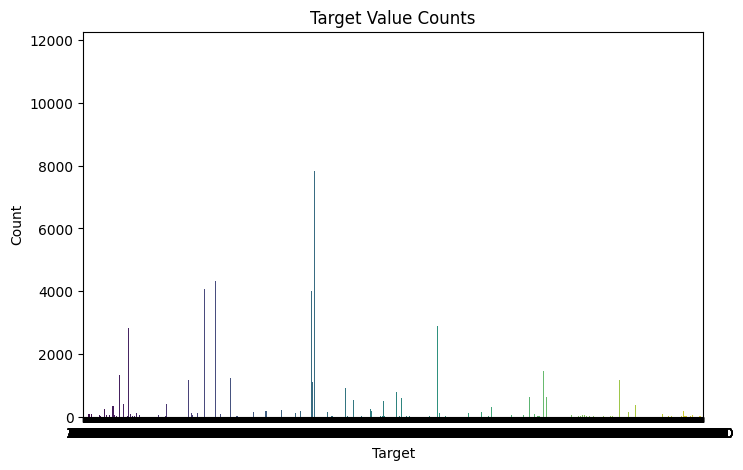

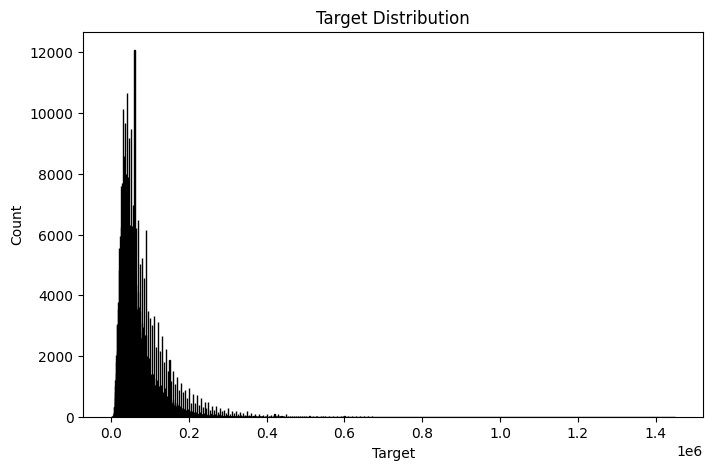

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns

# 값 개수 확인
counts = train['target'].value_counts()

# 1️⃣ 막대그래프
plt.figure(figsize=(8,5))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Value Counts')
plt.show()

# 2️⃣ (선택) 히스토그램
plt.figure(figsize=(8,5))
plt.hist(train['target'], bins=len(counts), color='skyblue', edgecolor='black')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()


In [369]:
train

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000


In [370]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [371]:
school.head()

,학교ID,학교명,학교급구분,설립일자,설립형태,본교분교구분,운영상태,소재지지번주소,소재지도로명주소,시도교육청코드,시도교육청명,교육지원청코드,교육지원청명,생성일자,변경일자,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,B000030750,대전둔곡초등학교,초등학교,2024-09-01,공립,본교,운영,대전광역시 유성구 둔곡동 261-4,대전광역시 유성구 과학인재4길 10,7430000,대전광역시교육청,7451000,대전광역시서부교육지원청,2013-11-29,2024-08-29,36.453175,127.364639,2025-03-25,B555223,재단법인한국지방교육행정연구재단
1,B000030751,대전둔곡중학교,중학교,2024-09-01,공립,본교,운영,대전광역시 유성구 둔곡동 261-4,대전광역시 유성구 과학인재4길 10,7430000,대전광역시교육청,7451000,대전광역시서부교육지원청,2013-11-29,NaN,36.453175,127.364639,2025-03-25,B555223,재단법인한국지방교육행정연구재단
2,B000010251,군산동산중학교,중학교,2005-03-02,공립,본교,운영,전북특별자치도 군산시 지곡동 616,전북특별자치도 군산시 동지곡길 100,8321000,전북특별자치도교육청,8342000,전북특별자치도군산교육지원청,2013-11-29,2024-11-08,35.951047,126.706012,2025-03-25,B555223,재단법인한국지방교육행정연구재단
3,B000030756,하서초등학교,초등학교,1940-04-17,공립,본교,운영,전북특별자치도 부안군 하서면 장신리 72-1,전북특별자치도 부안군 하서면 석불로 68,8321000,전북특별자치도교육청,8462000,전북특별자치도부안교육지원청,2013-11-29,2024-11-08,35.717474,126.626249,2025-03-25,B555223,재단법인한국지방교육행정연구재단
4,B000030754,금사초등학교,초등학교,1946-06-01,공립,본교,운영,부산광역시 금정구 서동 134-13,부산광역시 금정구 윤산로 279,7150000,부산광역시교육청,7191000,부산광역시동래교육지원청,2013-11-29,2024-11-08,35.220496,129.104850,2025-03-25,B555223,재단법인한국지방교육행정연구재단


In [372]:
train['도로명']

0               언주로 3
1               언주로 3
2               언주로 3
3               언주로 3
4               언주로 3
              ...    
1118817    서오릉로21길 36
1118818    서오릉로21길 36
1118819    서오릉로21길 36
1118820    서오릉로21길 36
1118821      서애로1길 34
Name: 도로명, Length: 1118822, dtype: object

In [373]:
train.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [374]:
import numpy as np
import pandas as pd

tdf = train[pd.notna(train['좌표X']) & pd.notna(train['좌표Y'])]

In [375]:
train['address'] = train['시군구'] + ' ' + train['도로명']
test['address'] = train['시군구'] + ' ' + train['도로명']

In [376]:
bus_feature.isna().sum()

노드 ID     0
정류소번호     0
정류소명      0
X좌표       0
Y좌표       0
정류소 타입    0
dtype: int64

In [377]:
def split_sigungu(addr):
    구, 동 = None, None
    if not addr:
        return 구, 동

    m = re.search(r'([가-힣]+구)\s*', addr)
    if m:
        구 = m.group(1)

        rest = addr[m.end():]
        m2 = re.search(r'([가-힣]+동)', rest)
        if m2:
            동 = m2.group(1)
    
    return 구, 동

train[['구','동']] = train['시군구'].apply(lambda x: pd.Series(split_sigungu(x)))
test[['구','동']] = test['시군구'].apply(lambda x: pd.Series(split_sigungu(x)))

In [378]:
train = train.rename(columns={
    "좌표X": "X",
    "좌표Y": "Y"
})

test = test.rename(columns={
    "좌표X": "X",
    "좌표Y": "Y"
})

bus_feature = bus_feature.rename(columns={
    "X좌표": "X",
    "Y좌표": "Y"
})

subway_feature = subway_feature.rename(columns={
    "경도": "X",
    "위도": "Y"
})

school = school.rename(columns={
    "경도": "X",
    "위도": "Y"
})

In [379]:
t_cnt = len(train)

In [380]:
tstd = int(t_cnt * 0.5)

In [381]:
train['X'].isnull().sum()

869670

In [382]:
drop_features = []
drop_features.append('해제사유발생일')

In [383]:
for c in train.columns:
    if train[c].isnull().sum() >= tstd:
        drop_features.append(c)

In [384]:
len(drop_features)

38

In [385]:
len(train.columns)

55

In [386]:
train.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,...,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,X,Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,...,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,...,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,...,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,...,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,...,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,...,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,...,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


In [387]:
unique_a_set = list(set(train.columns) - set(drop_features))
print(unique_a_set)

['계약일', '계약년월', '시군구', 'target', '거래유형', '층', '구', '등기신청일자', '중개사소재지', '전용면적(㎡)', '번지', '본번', '아파트명', '동', '도로명', '건축년도', 'address', '부번']


In [388]:
train_df = train[unique_a_set]
cols = [col for col in unique_a_set if col != 'target']
test = test[cols]

In [389]:
train_df

,계약일,계약년월,시군구,target,거래유형,층,구,등기신청일자,중개사소재지,전용면적(㎡),번지,본번,아파트명,동,도로명,건축년도,address,부번
0,8,201712,서울특별시 강남구 개포동,124000,-,3,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
1,22,201712,서울특별시 강남구 개포동,123500,-,4,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
2,28,201712,서울특별시 강남구 개포동,91500,-,5,강남구,,-,54.98,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
3,3,201801,서울특별시 강남구 개포동,130000,-,4,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
4,8,201801,서울특별시 강남구 개포동,117000,-,2,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,12,200707,서울특별시 은평구 구산동,20000,-,11,은평구,,-,59.94,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118818,25,200708,서울특별시 은평구 구산동,20000,-,10,은평구,,-,59.94,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118819,31,200708,서울특별시 은평구 구산동,28000,-,20,은평구,,-,84.83,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118820,15,200709,서울특별시 은평구 구산동,29000,-,8,은평구,,-,84.83,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0


In [390]:
train_df

,계약일,계약년월,시군구,target,거래유형,층,구,등기신청일자,중개사소재지,전용면적(㎡),번지,본번,아파트명,동,도로명,건축년도,address,부번
0,8,201712,서울특별시 강남구 개포동,124000,-,3,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
1,22,201712,서울특별시 강남구 개포동,123500,-,4,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
2,28,201712,서울특별시 강남구 개포동,91500,-,5,강남구,,-,54.98,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
3,3,201801,서울특별시 강남구 개포동,130000,-,4,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
4,8,201801,서울특별시 강남구 개포동,117000,-,2,강남구,,-,79.97,658-1,658.0,개포6차우성,개포동,언주로 3,1987,서울특별시 강남구 개포동 언주로 3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,12,200707,서울특별시 은평구 구산동,20000,-,11,은평구,,-,59.94,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118818,25,200708,서울특별시 은평구 구산동,20000,-,10,은평구,,-,59.94,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118819,31,200708,서울특별시 은평구 구산동,28000,-,20,은평구,,-,84.83,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0
1118820,15,200709,서울특별시 은평구 구산동,29000,-,8,은평구,,-,84.83,382,382.0,갈현현대,구산동,서오릉로21길 36,1998,서울특별시 은평구 구산동 서오릉로21길 36,0.0


In [391]:
addr_dict = address.set_index('address')[['X', 'Y']].to_dict('index')
def addr_feature(d, a):
    a = a.strip()
    if a in d:
        return d[a]['X'], d[a]['Y']
    else:
        return float('nan'), float('nan')

In [392]:
train_df[['X','Y']] = train_df['address'].apply(lambda x: pd.Series(addr_feature(addr_dict, x)))

In [393]:
test[['X','Y']] = test['address'].apply(lambda x: pd.Series(addr_feature(addr_dict, x)))

In [394]:
train_df = train_df.drop(columns=['address'])
test = test.drop(columns=['address'])

In [395]:
train_df['계약년'] = train_df['계약년월'].astype(str).str[:4].astype(int)
test['계약년'] = test['계약년월'].astype(str).str[:4].astype(int)

In [396]:
train_df['건물나이'] = train_df['계약년'] - train['건축년도']
test['건물나이'] = test['계약년'] - test['건축년도']

In [397]:
test

,계약일,계약년월,시군구,거래유형,층,구,등기신청일자,중개사소재지,전용면적(㎡),번지,본번,아파트명,동,도로명,건축년도,부번,X,Y,계약년,건물나이
0,26,202307,서울특별시 강남구 개포동,직거래,5,강남구,,-,79.9700,658-1,658.0,개포6차우성,개포동,언주로 3,1987,1.0,127.056841,37.476283,2023,36
1,15,202308,서울특별시 강남구 개포동,중개거래,10,강남구,,서울 강남구,108.2017,651-1,651.0,개포더샵트리에,개포동,개포로 311,2021,1.0,127.056841,37.476283,2023,2
2,28,202307,서울특별시 강남구 개포동,중개거래,15,강남구,,서울 강남구,161.0000,652,652.0,개포우성3차,개포동,개포로 307,1984,0.0,127.056841,37.476283,2023,39
3,10,202308,서울특별시 강남구 개포동,중개거래,14,강남구,,서울 강남구,133.4600,652,652.0,개포우성3차,개포동,개포로 307,1984,0.0,127.056841,37.476283,2023,39
4,18,202308,서울특별시 강남구 개포동,중개거래,6,강남구,,서울 강남구,104.4300,652,652.0,개포우성3차,개포동,개포로 307,1984,0.0,127.056841,37.476283,2023,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,19,202307,서울특별시 중랑구 신내동,직거래,13,중랑구,,-,84.6500,816,816.0,신내우디안1단지,신내동,신내역로1길 85,2014,0.0,127.127620,37.544376,2023,9
9268,25,202307,서울특별시 중랑구 신내동,중개거래,12,중랑구,,서울 중랑구,84.6200,816,816.0,신내우디안1단지,신내동,신내역로1길 85,2014,0.0,127.127620,37.544376,2023,9
9269,27,202308,서울특별시 중랑구 신내동,중개거래,12,중랑구,,서울 중랑구,101.6500,816,816.0,신내우디안1단지,신내동,신내역로1길 85,2014,0.0,127.127620,37.544376,2023,9
9270,2,202309,서울특별시 중랑구 신내동,중개거래,18,중랑구,,서울 중랑구,84.9400,816,816.0,신내우디안1단지,신내동,신내역로1길 85,2014,0.0,127.127620,37.544376,2023,9


In [398]:
import pandas as pd

train_df['월'] = train_df['계약년월'] % 100   # 뒷 두 자리만 가져오기

# 2. '계절' 생성 (봄=3~5, 여름=6~8, 가을=9~11, 겨울=12~2)
def get_season(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

train_df['계절'] = train_df['월'].apply(get_season)
train_df['분기'] = ((train_df['월'] - 1) // 3) + 1
train_df['계약년월_dt'] = pd.to_datetime(train_df['계약년월'].astype(str), format='%Y%m')

# 시간 순 정렬 후 라벨링
unique_months = train_df['계약년월_dt'].sort_values().unique()
month2label = {month: idx for idx, month in enumerate(unique_months)}
train_df['계약년월_label'] = train_df['계약년월_dt'].map(month2label)

test['월'] = test['계약년월'] % 100

test['계절'] = test['월'].apply(get_season)
test['분기'] = ((test['월'] - 1) // 3) + 1
test['계약년월_dt'] = pd.to_datetime(test['계약년월'].astype(str), format='%Y%m')
unique_months = test['계약년월_dt'].sort_values().unique()
month2label = {month: idx for idx, month in enumerate(unique_months)}
test['계약년월_label'] = test['계약년월_dt'].map(month2label)

print(train_df[['계약년월', '월', '계절', '분기', '계약년월_label']].head(10))

     계약년월   월  계절  분기  계약년월_label
0  201712  12   3   4         131
1  201712  12   3   4         131
2  201712  12   3   4         131
3  201801   1   3   1         132
4  201801   1   3   1         132
5  201801   1   3   1         132
6  201803   3   0   1         134
7  201804   4   0   2         135
8  201806   6   1   2         137
9  201807   7   1   3         138


In [399]:
train_df.head()

,계약일,계약년월,시군구,target,거래유형,층,구,등기신청일자,중개사소재지,전용면적(㎡),...,부번,X,Y,계약년,건물나이,월,계절,분기,계약년월_dt,계약년월_label
0,8,201712,서울특별시 강남구 개포동,124000,-,3,강남구,,-,79.97,...,1.0,127.056841,37.476283,2017,30,12,3,4,2017-12-01,131
1,22,201712,서울특별시 강남구 개포동,123500,-,4,강남구,,-,79.97,...,1.0,127.056841,37.476283,2017,30,12,3,4,2017-12-01,131
2,28,201712,서울특별시 강남구 개포동,91500,-,5,강남구,,-,54.98,...,1.0,127.056841,37.476283,2017,30,12,3,4,2017-12-01,131
3,3,201801,서울특별시 강남구 개포동,130000,-,4,강남구,,-,79.97,...,1.0,127.056841,37.476283,2018,31,1,3,1,2018-01-01,132
4,8,201801,서울특별시 강남구 개포동,117000,-,2,강남구,,-,79.97,...,1.0,127.056841,37.476283,2018,31,1,3,1,2018-01-01,132


In [400]:
school

,학교ID,학교명,학교급구분,설립일자,설립형태,본교분교구분,운영상태,소재지지번주소,소재지도로명주소,시도교육청코드,시도교육청명,교육지원청코드,교육지원청명,생성일자,변경일자,Y,X,데이터기준일자,제공기관코드,제공기관명
0,B000030750,대전둔곡초등학교,초등학교,2024-09-01,공립,본교,운영,대전광역시 유성구 둔곡동 261-4,대전광역시 유성구 과학인재4길 10,7430000,대전광역시교육청,7451000,대전광역시서부교육지원청,2013-11-29,2024-08-29,36.453175,127.364639,2025-03-25,B555223,재단법인한국지방교육행정연구재단
1,B000030751,대전둔곡중학교,중학교,2024-09-01,공립,본교,운영,대전광역시 유성구 둔곡동 261-4,대전광역시 유성구 과학인재4길 10,7430000,대전광역시교육청,7451000,대전광역시서부교육지원청,2013-11-29,NaN,36.453175,127.364639,2025-03-25,B555223,재단법인한국지방교육행정연구재단
2,B000010251,군산동산중학교,중학교,2005-03-02,공립,본교,운영,전북특별자치도 군산시 지곡동 616,전북특별자치도 군산시 동지곡길 100,8321000,전북특별자치도교육청,8342000,전북특별자치도군산교육지원청,2013-11-29,2024-11-08,35.951047,126.706012,2025-03-25,B555223,재단법인한국지방교육행정연구재단
3,B000030756,하서초등학교,초등학교,1940-04-17,공립,본교,운영,전북특별자치도 부안군 하서면 장신리 72-1,전북특별자치도 부안군 하서면 석불로 68,8321000,전북특별자치도교육청,8462000,전북특별자치도부안교육지원청,2013-11-29,2024-11-08,35.717474,126.626249,2025-03-25,B555223,재단법인한국지방교육행정연구재단
4,B000030754,금사초등학교,초등학교,1946-06-01,공립,본교,운영,부산광역시 금정구 서동 134-13,부산광역시 금정구 윤산로 279,7150000,부산광역시교육청,7191000,부산광역시동래교육지원청,2013-11-29,2024-11-08,35.220496,129.104850,2025-03-25,B555223,재단법인한국지방교육행정연구재단
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11980,B000012610,소하고등학교,고등학교,1997-03-01,공립,본교,운영,경기도 광명시 소하동 1330,경기도 광명시 소하일로 21,7530000,경기도교육청,7591000,경기도광명교육지원청,2013-11-29,2024-11-08,37.447246,126.887582,2025-03-25,B555223,재단법인한국지방교육행정연구재단
11981,B000026772,아산세교초등학교,초등학교,2023-03-01,공립,본교,운영,충청남도 아산시 배방읍 세교리 1530,충청남도 아산시 배방읍 동방로 200,8140000,충청남도교육청,8181000,충청남도아산교육지원청,2013-11-29,2024-11-08,36.777966,127.092236,2025-03-25,B555223,재단법인한국지방교육행정연구재단
11982,B000003138,인천경서초등학교,초등학교,2005-05-02,공립,본교,운영,인천광역시 서구 경서동 741,인천광역시 서구 경서로31번길 31,7310000,인천광역시교육청,7361000,인천광역시서부교육지원청,2013-11-29,2024-11-08,37.556661,126.650985,2025-03-25,B555223,재단법인한국지방교육행정연구재단
11983,B000004177,한마음초등학교,초등학교,2008-03-01,공립,본교,운영,경기도 화성시 능동 1117,경기도 화성시 동탄숲속로 69-6,7530000,경기도교육청,7679000,경기도화성오산교육지원청,2013-11-29,2024-11-08,37.208593,127.056359,2025-03-25,B555223,재단법인한국지방교육행정연구재단


In [401]:
from scipy.spatial import cKDTree
import numpy as np

school_coords = school[['X', 'Y']].values

train_apt_coords = train_df[['X', 'Y']].values
test_apt_coords = test[['X', 'Y']].values

# 좌표계 판단 (경위도 vs 미터)
is_latlon = (train_apt_coords[:, 0].max() < 200)

if is_latlon:
    radius = 500 / 111000  # 500m를 도로 변환
else:
    radius = 500

# KDTree 생성
school_tree = cKDTree(school_coords)

# 최근접 거리 계산
train_dist_sc, _ = school_tree.query(train_apt_coords, k=1)

test_dist_sc, _ = school_tree.query(test_apt_coords, k=1)

# 반경 내 개수 계산
train_sc_counts = [len(school_tree.query_ball_point(coord, r=radius)) for coord in train_apt_coords]

test_sc_counts = [len(school_tree.query_ball_point(coord, r=radius)) for coord in test_apt_coords]

# 데이터프레임에 추가
train_df['가까운학교거리'] = train_dist_sc
train_df['500m내학교역개수'] = train_sc_counts

test['가까운학교거리'] = test_dist_sc
test['500m내학교역개수'] = test_sc_counts

In [402]:
from scipy.spatial import cKDTree
import numpy as np

bus_coords = bus_feature[['X', 'Y']].values
subway_coords = subway_feature[['X', 'Y']].values

train_apt_coords = train_df[['X', 'Y']].values
test_apt_coords = test[['X', 'Y']].values

# 좌표계 판단 (경위도 vs 미터)
is_latlon = (train_apt_coords[:, 0].max() < 200)

if is_latlon:
    radius = 500 / 111000  # 500m를 도로 변환
else:
    radius = 500

# KDTree 생성
bus_tree = cKDTree(bus_coords)
subway_tree = cKDTree(subway_coords)

# 최근접 거리 계산
train_dist_bus, _ = bus_tree.query(train_apt_coords, k=1)
train_dist_subway, _ = subway_tree.query(train_apt_coords, k=1)

test_dist_bus, _ = bus_tree.query(test_apt_coords, k=1)
test_dist_subway, _ = subway_tree.query(test_apt_coords, k=1)

# 반경 내 개수 계산
train_bus_counts = [len(bus_tree.query_ball_point(coord, r=radius)) for coord in train_apt_coords]
train_subway_counts = [len(subway_tree.query_ball_point(coord, r=radius)) for coord in train_apt_coords]

test_bus_counts = [len(bus_tree.query_ball_point(coord, r=radius)) for coord in test_apt_coords]
test_subway_counts = [len(subway_tree.query_ball_point(coord, r=radius)) for coord in test_apt_coords]

# 데이터프레임에 추가
train_df['가까운버스역거리'] = train_dist_bus
train_df['가까운지하철역거리'] = train_dist_subway
train_df['500m내버스역개수'] = train_bus_counts
train_df['500m내지하철역개수'] = train_subway_counts

test['가까운버스역거리'] = test_dist_bus
test['가까운지하철역거리'] = test_dist_subway
test['500m내버스역개수'] = test_bus_counts
test['500m내지하철역개수'] = test_subway_counts

# 결과 확인
print(f"버스역 개수 - 평균: {np.mean(train_bus_counts):.1f}, 최대: {np.max(train_bus_counts)}")
print(f"지하철역 개수 - 평균: {np.mean(train_subway_counts):.1f}, 최대: {np.max(train_subway_counts)}")

버스역 개수 - 평균: 19.5, 최대: 62
지하철역 개수 - 평균: 0.6, 최대: 6


In [403]:
gus = list(set(train_df['구']))

In [404]:
len(gus)

25

In [405]:
gu_dict = {}

In [406]:
for g in gus:
    mean_val = train_df[train_df['구'] == g]['target'].mean()
    print(f"{g}: {mean_val}")
    print(f"{g}: {len(train_df[train_df['구'] == g])}")
    gu_dict[g] = mean_val

중구: 62084.98573349268
중구: 13388
관악구: 41954.13303861873
관악구: 35967
노원구: 33870.44473018879
노원구: 115099
용산구: 105876.96189966425
용산구: 20551
강동구: 54402.87280071088
강동구: 61895
서초구: 113608.65339005383
서초구: 53126
서대문구: 49082.57368821293
서대문구: 32875
영등포구: 56137.3424643157
영등포구: 47640
도봉구: 31924.613710720536
도봉구: 52572
송파구: 83868.03291997018
송파구: 73785
종로구: 57674.03296341062
종로구: 9101
강남구: 114847.46150282993
강남구: 69083
동작구: 60936.451057841856
동작구: 40507
광진구: 67158.37929315813
광진구: 22070
중랑구: 35195.76281878471
중랑구: 37094
성북구: 45117.779038376706
성북구: 56675
금천구: 33709.24864699275
금천구: 19586
구로구: 38605.012447052286
구로구: 57604
마포구: 64445.22613712333
마포구: 40387
강서구: 44215.45370064555
강서구: 66610
성동구: 68924.38939986788
성동구: 39358
은평구: 43721.69184755636
은평구: 38283
양천구: 59042.13292698742
양천구: 53977
강북구: 38316.97520094994
강북구: 21896
동대문구: 45194.761821983724
동대문구: 39693


In [407]:
train_dict = {}
test_dict = {}
for g in gus:
    train_dict[g] = train_df[train_df['구']==g]
    test_dict[g] = test[train_df['구']==g]

In [408]:
train_dict['강남구']

,계약일,계약년월,시군구,target,거래유형,층,구,등기신청일자,중개사소재지,전용면적(㎡),...,계절,분기,계약년월_dt,계약년월_label,가까운학교거리,500m내학교역개수,가까운버스역거리,가까운지하철역거리,500m내버스역개수,500m내지하철역개수
0,8,201712,서울특별시 강남구 개포동,124000,-,3,강남구,,-,79.97,...,3,4,2017-12-01,131,0.004346,1,0.001061,0.010747,10,0
1,22,201712,서울특별시 강남구 개포동,123500,-,4,강남구,,-,79.97,...,3,4,2017-12-01,131,0.004346,1,0.001061,0.010747,10,0
2,28,201712,서울특별시 강남구 개포동,91500,-,5,강남구,,-,54.98,...,3,4,2017-12-01,131,0.004346,1,0.001061,0.010747,10,0
3,3,201801,서울특별시 강남구 개포동,130000,-,4,강남구,,-,79.97,...,3,1,2018-01-01,132,0.004346,1,0.001061,0.010747,10,0
4,8,201801,서울특별시 강남구 개포동,117000,-,2,강남구,,-,79.97,...,3,1,2018-01-01,132,0.004346,1,0.001061,0.010747,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118450,17,200705,서울특별시 강남구 일원동,73000,-,5,강남구,,-,74.54,...,0,2,2007-05-01,4,0.002764,3,0.000777,0.002800,13,1
1118451,6,200706,서울특별시 강남구 일원동,79000,-,2,강남구,,-,74.54,...,1,2,2007-06-01,5,0.002764,3,0.000777,0.002800,13,1
1118452,19,200706,서울특별시 강남구 일원동,79000,-,3,강남구,,-,74.54,...,1,2,2007-06-01,5,0.002764,3,0.000777,0.002800,13,1
1118453,4,200707,서울특별시 강남구 일원동,76100,-,1,강남구,,-,74.54,...,1,3,2007-07-01,6,0.002764,3,0.000777,0.002800,13,1


In [409]:
sorted_items = sorted(gu_dict.items(), key=lambda x: x[1])

ranked_dict_loc_gu = {gu: rank for rank, (gu, val) in enumerate(sorted_items)}

print(ranked_dict_loc_gu)

{'도봉구': 0, '금천구': 1, '노원구': 2, '중랑구': 3, '강북구': 4, '구로구': 5, '관악구': 6, '은평구': 7, '강서구': 8, '성북구': 9, '동대문구': 10, '서대문구': 11, '강동구': 12, '영등포구': 13, '종로구': 14, '양천구': 15, '동작구': 16, '중구': 17, '마포구': 18, '광진구': 19, '성동구': 20, '송파구': 21, '용산구': 22, '서초구': 23, '강남구': 24}


In [410]:
def labeling_encoding(data,d):
    return d[data]

In [411]:
trade_type_dict = {'직거래':0, '-':1, '중개거래':2}

In [412]:
for g in gus:
    train_d = train_dict[g]
    train_d['구'] = train_d['구'].apply(lambda x: pd.Series(labeling_encoding(x,ranked_dict_loc_gu)))
    
    train_d['거래유형'] = train_d['거래유형'].apply(lambda x: pd.Series(labeling_encoding(x,trade_type_dict)))

    string_cols = list(train_d.select_dtypes(include=['object']).columns)
    print(string_cols)

    train_d = train_d.drop(columns=string_cols)
    
    train_d = train_d.drop(columns=['X','Y','계약년월_dt'])
    
    train_dict[g] = train_d

['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']
['시군구', '등기신청일자', '중개사소재지', 

In [413]:
test['구'] = test['구'].apply(lambda x: pd.Series(labeling_encoding(x,ranked_dict_loc_gu)))
    
test['거래유형'] = test['거래유형'].apply(lambda x: pd.Series(labeling_encoding(x,trade_type_dict)))
tring_cols = list(train_d.select_dtypes(include=['object']).columns)
print(string_cols)
test = test.drop(columns=string_cols)
test = test.drop(columns=['X','Y','계약년월_dt'])

['시군구', '등기신청일자', '중개사소재지', '번지', '아파트명', '동', '도로명']


In [414]:
from sklearn.preprocessing import StandardScaler
Xs = [] 
ys = []
scalers = []
y_scaleds = []

for g in gus:
    train_df = train_dict[g]
    X = train_df.drop('target', axis=1)
    y = train_df['target'].values.reshape(-1, 1)
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y)
    Xs.append(X)
    ys.append(y)
    scalers.append(scaler)
    y_scaleds.append(y_scaled)

In [415]:
y_scaleds[0]

array([[ 0.39161629],
       [ 0.56047689],
       [ 0.33530128],
       ...,
       [-1.33920491],
       [-1.29698976],
       [-1.3743842 ]])

In [ ]:
idx = 0
model_dict = {}
for g in gus:
    X = Xs[idx]
    y_scaled = y_scaleds[idx]
    X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled,
    test_size=0.2,
    random_state=42
    )

    model = LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_dict[ranked_dict_loc_gu[g]] = model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_original = rmse * scaler.scale_[0]  # scale_가 표준편차
    print(rmse_original)
    idx+=1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 10710, number of used features: 20
[LightGBM] [Info] Start training from score 0.003054
4348.491577019007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 28773, number of used features: 20
[LightGBM] [Info] Start training from score -0.000514
4148.864550378132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1772
[LightGBM] [Info] N

In [417]:
len(test.columns)

21

In [418]:
Xs[0].columns

Index(['계약일', '계약년월', '거래유형', '층', '구', '전용면적(㎡)', '본번', '건축년도', '부번', '계약년',
       '건물나이', '월', '계절', '분기', '계약년월_label', '가까운학교거리', '500m내학교역개수',
       '가까운버스역거리', '가까운지하철역거리', '500m내버스역개수', '500m내지하철역개수'],
      dtype='object')

In [419]:
std_preds = []

for i in range(len(test)):
    print(i)
    gu = test.iloc[i]['구']
    model = model_dict[gu]
    
    row = test.iloc[i:i+1]
    pred = model.predict(row)[0]
    
    std_preds.append(pred)

std_preds = np.array(std_preds)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [420]:
std_preds

array([0.68270647, 2.04887733, 3.1940369 , ..., 2.74305442, 2.36569473,
       2.24242478])

In [421]:
preds = scaler.inverse_transform(std_preds.reshape(-1,1))
preds

array([[ 60729.75481328],
       [ 91816.98752838],
       [117875.10599669],
       ...,
       [107612.99467715],
       [ 99026.171001  ],
       [ 96221.16197328]])

In [422]:
submission = pd.DataFrame({'target': preds[:, 0].astype(int)})

In [423]:
submission

,target
0,60729
1,91816
2,117875
3,94475
4,76867
...,...
9267,96560
9268,98372
9269,107612
9270,99026


In [424]:
submission.to_csv('test_submission.csv', index=False)